## Printing histograms

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
x = np.random.randint(0, 100, 100)

In [3]:
x.shape

(100,)

In [7]:
np.histogram(x, bins = 10 * np.arange(11))

(array([ 8, 11,  4, 10, 12, 11, 17, 13,  6,  8]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100]))

In [9]:
((x >= 0) & (x <= 10)).sum()

9

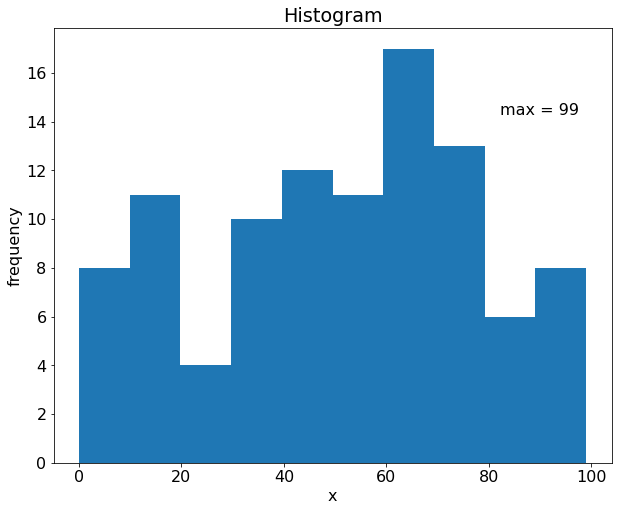

In [17]:
plt.figure(figsize = (10, 8))
plt.rcParams.update({"font.size": 16})

plt.hist(x, bins=10)
ax = plt.gca()

plt.title("Histogram")
plt.xlabel("x")
plt.ylabel("frequency")

plt.text(0.8, 0.8, "max = {}".format(x.max()), transform=ax.transAxes)

plt.show()

## MPQA3 target labeler data

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from keras.preprocessing.sequence import pad_sequences
import os
import json
from tqdm import tqdm
from transformers import BertTokenizer

In [2]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

In [3]:
fold_df = pd.read_csv("/workspace/opinion/results/opinion-mining/mpqa3/2fold.csv", index_col=None)

In [4]:
fold_df.head()

,doc_id,fold
0,temp_fbis/20.46.39-9348,0
1,20011114/21.16.57-11242,0
2,non_fbis/08.39.09-12713,0
3,non_fbis/12.21.28-26118,0
4,temp_fbis/20.57.35-19171,0


In [5]:
train_ids = fold_df.loc[fold_df["fold"] == 0, "doc_id"].values

In [6]:
train_ids

array(['temp_fbis/20.46.39-9348', '20011114/21.16.57-11242',
       'non_fbis/08.39.09-12713', 'non_fbis/12.21.28-26118',
       'temp_fbis/20.57.35-19171', 'non_fbis/16.01.44-19040',
       'temp_fbis/20.45.06-5529', 'non_fbis/09.53.15-23595',
       'temp_fbis/20.13.06-23605', 'non_fbis/10.24.29-21670',
       'non_fbis/07.29.33-28852', 'temp_fbis/20.46.47-22286',
       '20011024/21.53.09-11428', 'non_fbis/13.21.23-8227',
       '20020306/20.49.12-24038', 'non_fbis/12.15.47-5091',
       'non_fbis/08.36.15-7509', 'non_fbis/08.14.55-18533',
       'temp_fbis/21.31.45-20536', 'non_fbis/08.40.56-18707',
       'non_fbis/11.04.20-23621', 'non_fbis/11.21.37-22256',
       '20020207/20.22.42-14586', 'non_fbis/08.47.00-17401',
       '20020318/20.33.16-3417', 'non_fbis/05.20.33-11163',
       '20020206/20.31.05-16359', '20020507/17.55.10-20068',
       'temp_fbis/20.58.47-19000', 'non_fbis/04.51.05-27505',
       'temp_fbis/21.37.46-9337', 'temp_fbis/20.20.10-3414',
       'temp_fbis/21.39

In [7]:
text = "For all she lamented how her brother's mind shattered, many memories lost to the abyss of time, Arya found that much of her life in the North was harder and harder to recollect."

In [8]:
tokens = tokenizer.tokenize(text)

In [9]:
tokens

['For',
 'all',
 'she',
 'lame',
 '##nted',
 'how',
 'her',
 'brother',
 "'",
 's',
 'mind',
 'shattered',
 ',',
 'many',
 'memories',
 'lost',
 'to',
 'the',
 'a',
 '##byss',
 'of',
 'time',
 ',',
 'A',
 '##rya',
 'found',
 'that',
 'much',
 'of',
 'her',
 'life',
 'in',
 'the',
 'North',
 'was',
 'harder',
 'and',
 'harder',
 'to',
 're',
 '##co',
 '##lle',
 '##ct',
 '.']

In [10]:
tokenizer.convert_tokens_to_ids(tokens)

[1370,
 1155,
 1131,
 25492,
 16736,
 1293,
 1123,
 1711,
 112,
 188,
 1713,
 11670,
 117,
 1242,
 5628,
 1575,
 1106,
 1103,
 170,
 24598,
 1104,
 1159,
 117,
 138,
 20845,
 1276,
 1115,
 1277,
 1104,
 1123,
 1297,
 1107,
 1103,
 1456,
 1108,
 5747,
 1105,
 5747,
 1106,
 1231,
 2528,
 4838,
 5822,
 119]

In [11]:
max_seq_len = 100

In [12]:
wordids_list = []
pos_list = []
mask_list = []
label_list = []

In [ ]:
for id in train_ids:
    file = os.path.join("/workspace/opinion/results/preprocessing-mpqa/mpqa3-processed/", id, "tokenized.json")
    doc = json.load(open(file))

    for sentence in doc:

        n_previous_tokens = np.zeros(len(sentence["tokens"]) + 1)
        wordpiece_tokens = []

        for i, token in enumerate(sentence["tokens"]):
            wordpiece_tokens_from_single_token = tokenizer.tokenize(token)
            wordpiece_tokens.extend(wordpiece_tokens_from_single_token)
            n_previous_tokens[i + 1] = n_previous_tokens[i] + len(wordpiece_tokens_from_single_token)

        dse_and_target_to_etarget = {}

        for dse in sentence["dse"]:

            if dse["dse-span"] and dse["target-type"] == "span":

                old_dse_span = dse["dse-span"]
                new_dse_span = [n_previous_tokens[old_dse_span[0]], n_previous_tokens[old_dse_span[1]]]

                old_target_span = dse["target-span"]
                new_target_span = [n_previous_tokens[old_target_span[0]], n_previous_tokens[old_target_span[1]]]

                dse_and_target_key = new_dse_span + new_target_span
                dse_and_target_to_etarget[tuple(dse_and_target_key)] = set()
        


                

## Check if there is a one-to-one correspondence between DSE and SPAN TARGET in MPQA 3

In [15]:
import json
import os
from tqdm import tqdm
from collections import Counter, defaultdict

In [13]:
mpqa3_docids = open("/workspace/opinion/data/30-mpqa/database.mpqa.3.0/doclist").read().splitlines()
mpqa3_docs = [json.load(open(os.path.join("/workspace/opinion/results/preprocessing-mpqa/mpqa3-processed/", docid, "tokenized.json"))) for docid in mpqa3_docids]

In [16]:
dse_to_span_targets = []

for doc in tqdm(mpqa3_docs):

    for sentence in doc:

        dse_to_span_target = defaultdict(lambda: set())

        for dse in sentence["dse"]:

            if dse["dse-span"] and dse["target-type"] == "span":

                dse_span = tuple(dse["dse-span"])
                target_span = tuple(dse["target-span"])

                dse_to_span_target[dse_span].add(target_span)

        if dse_to_span_target:

            dse_to_span_targets.append(dse_to_span_target)

100%|██████████| 70/70 [00:00<00:00, 14234.52it/s]


In [18]:
n_span_targets_per_dse = []

for dse_to_span_target in dse_to_span_targets:
    for span_targets in dse_to_span_target.values():
        n_span_targets_per_dse.append(len(span_targets))

In [19]:
Counter(n_span_targets_per_dse)

Counter({1: 1073, 2: 138, 7: 1, 3: 17, 4: 2})

## MPQA 3: check if etargets linked to stargets fall within the latter's span (use processed files)

In [1]:
import os
import json
from tqdm import tqdm
from collections import Counter, defaultdict

In [4]:
mpqa3_docids = open("/workspace/opinion/data/30-mpqa/database.mpqa.3.0/doclist").read().splitlines()
mpqa3_docs = [json.load(open(os.path.join("/workspace/opinion/results/preprocessing-mpqa/mpqa3-processed/", docid, "processed.json"))) for docid in mpqa3_docids]

In [14]:
n_stargets = 0

n_linked_etargets = 0
n_unlinked_etargets = 0

n_linked_and_subsumed_etargets = 0
n_linked_and_intersect_etargets = 0
n_linked_and_disjoint_etargets = 0
# checking overlap with only the linked starget

n_unlinked_and_subsumed_etargets = 0
n_unlinked_and_intersect_etargets = 0
n_unlinked_and_disjoint_etargets = 0
# checking overlap with any of the tgtframe starget

for doc in mpqa3_docs:

    for dse in doc["dse"]:

        for att in dse["matched-attitudes"]:

            tgtframe = att["matched-targetframe"]

            if tgtframe is not None:

                for starget in tgtframe["matched-stargets"]:

                    starget_span = starget["span"]
                    etarget_spans = []

                    for etarget in starget["matched-etargets"]:

                        if etarget["type"] in ["entity", "event"]:
                            etarget_spans.append(etarget["span"])
                    
                    n_stargets += 1

                    for etarget_span in etarget_spans:

                        if starget_span["start"] <= etarget_span["start"] <= etarget_span["end"] <= starget_span["end"]:
                            n_linked_and_subsumed_etargets += 1
                        
                        elif starget_span["end"] <= etarget_span["start"] or etarget_span["end"] <= starget_span["start"]:
                            n_linked_and_disjoint_etargets += 1
                        
                        else:
                            n_linked_and_intersect_etargets += 1
                        
                        n_linked_etargets += 1
                
                for etarget in tgtframe["matched-etargets"]:

                    if etarget["type"] in ["entity", "event"]:

                        etarget_span = etarget["span"]

                        is_subsumed = False
                        is_disjoint = True
                        is_intersect = False

                        for starget in tgtframe["matched-stargets"]:

                            starget_span = starget["span"]

                            if starget_span["start"] <= etarget_span["start"] <= etarget_span["end"] <= starget_span["end"]:
                                is_subsumed = True
                            
                            elif starget_span["end"] <= etarget_span["start"] or etarget_span["end"] <= starget_span["start"]:
                                pass
                            
                            else:
                                is_intersect = True
                            
                        n_unlinked_etargets += 1

                        if is_subsumed:
                            n_unlinked_and_subsumed_etargets += 1
                        elif is_intersect:
                            n_unlinked_and_intersect_etargets += 1
                        else:
                            n_unlinked_and_disjoint_etargets += 1

In [15]:
print("{} stargets".format(n_stargets))
print("{} linked etargets  : {} subsumed, {} intersect, {} disjoint".format(n_linked_etargets, n_linked_and_subsumed_etargets, n_linked_and_intersect_etargets, n_linked_and_disjoint_etargets))
print("{} unlinked etargets: {} subsumed, {} intersect, {} disjoint".format(n_unlinked_etargets, n_unlinked_and_subsumed_etargets, n_unlinked_and_intersect_etargets, n_unlinked_and_disjoint_etargets))

2337 stargets
1657 linked etargets  : 1622 subsumed, 1 intersect, 34 disjoint
1506 unlinked etargets: 13 subsumed, 0 intersect, 1493 disjoint


In [16]:
mpqa3_tokenized_docs = [json.load(open(os.path.join("/workspace/opinion/results/preprocessing-mpqa/mpqa3-processed/", docid, "tokenized.json"))) for docid in mpqa3_docids]

In [17]:
n_stargets = 0
n_etargets = 0
n_linked_etargets = 0
n_unlinked_etargets = 0

for doc in mpqa3_tokenized_docs:

    for sentence in doc:

        for dse in sentence["dse"]:

            if dse["target-type"] == "span":
                n_stargets += 1
            
            else:
                
                if dse["linked-to"] == -1:
                    n_unlinked_etargets += 1
                
                else:
                    n_linked_etargets += 1
                
                n_etargets += 1

print("{} stargets".format(n_stargets))
print("{} etargets: {} linked, {} unlinked".format(n_etargets, n_linked_etargets, n_unlinked_etargets))

1995 stargets
2804 etargets: 1465 linked, 1339 unlinked


## Check WordPiece tokens of full sentence == WordPiece tokens of spacy tokens

In [21]:
from transformers import BertTokenizer
import json
import os
from tqdm import tqdm
from collections import Counter, defaultdict
import spacy

In [19]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

In [22]:
nlp = spacy.load("en_core_web_sm")

In [20]:
mpqa3_docids = open("/workspace/opinion/data/30-mpqa/database.mpqa.3.0/doclist").read().splitlines()
mpqa3_docs = [json.load(open(os.path.join("/workspace/opinion/results/preprocessing-mpqa/mpqa3-processed/", docid, "tokenized.json"))) for docid in mpqa3_docids]

In [23]:
n_sentences = 0
n_sentences_tokens_equal_spacy = 0
n_sentences_wordpiece_tokens_equal = 0

for doc in mpqa3_docs:

    for sentence in doc:

        text = sentence["text"]
        tokens = sentence["tokens"]

        spacy_tokens = [token.text for token in nlp(text)]

        wordpiece_tokens_from_text = tokenizer.tokenize(text)

        wordpiece_tokens_from_single_tokens = [t for token in tokens for t in tokenizer.tokenize(token)]

        n_sentences += 1
        n_sentences_tokens_equal_spacy += tokens == spacy_tokens
        n_sentences_wordpiece_tokens_equal += wordpiece_tokens_from_text == wordpiece_tokens_from_single_tokens

print("{} sentences".format(n_sentences))
print("{} sentences: tokens == spacy".format(n_sentences_tokens_equal_spacy))
print("{} sentences: wordpiece tokens from single token == wordpiece tokens from full text".format(n_sentences_wordpiece_tokens_equal))

1653 sentences
1653 sentences: tokens == spacy
1612 sentences: wordpiece tokens from single token == wordpiece tokens from full text


## Target Labeler Data

In [1]:
import torch

In [2]:
A = torch.randn((10, 3))
B = torch.randn((10, 1))

In [3]:
print(A)
print(B)

tensor([[ 0.2344,  0.5610,  1.2155],
        [ 0.7290, -0.2219, -0.5218],
        [-0.2209, -0.2749,  0.2222],
        [ 0.1837, -0.7419, -0.0564],
        [ 1.8950, -0.2207,  0.3677],
        [-0.7403,  0.0106,  0.0923],
        [-1.4558, -0.8410,  1.2017],
        [ 0.0238, -1.3848,  0.5263],
        [-0.6991, -0.5983,  0.6254],
        [-1.0088, -0.7490,  0.3808]])
tensor([[ 0.1963],
        [ 2.5080],
        [ 0.0825],
        [ 0.3849],
        [ 0.9214],
        [ 0.4008],
        [-1.0368],
        [ 2.3449],
        [-0.2258],
        [ 0.7244]])


In [4]:
A + B

tensor([[ 0.4306,  0.7572,  1.4118],
        [ 3.2371,  2.2861,  1.9862],
        [-0.1384, -0.1924,  0.3046],
        [ 0.5687, -0.3570,  0.3285],
        [ 2.8164,  0.7007,  1.2891],
        [-0.3394,  0.4115,  0.4931],
        [-2.4926, -1.8778,  0.1649],
        [ 2.3687,  0.9601,  2.8712],
        [-0.9249, -0.8242,  0.3996],
        [-0.2844, -0.0246,  1.1052]])

In [10]:
Z = torch.zeros((10, 1))

In [11]:
torch.hstack([A, Z])

tensor([[ 0.2344,  0.5610,  1.2155,  0.0000],
        [ 0.7290, -0.2219, -0.5218,  0.0000],
        [-0.2209, -0.2749,  0.2222,  0.0000],
        [ 0.1837, -0.7419, -0.0564,  0.0000],
        [ 1.8950, -0.2207,  0.3677,  0.0000],
        [-0.7403,  0.0106,  0.0923,  0.0000],
        [-1.4558, -0.8410,  1.2017,  0.0000],
        [ 0.0238, -1.3848,  0.5263,  0.0000],
        [-0.6991, -0.5983,  0.6254,  0.0000],
        [-1.0088, -0.7490,  0.3808,  0.0000]])

In [12]:
A[:,-1]

tensor([ 1.2155, -0.5218,  0.2222, -0.0564,  0.3677,  0.0923,  1.2017,  0.5263,
         0.6254,  0.3808])

In [16]:
M = torch.randint(0, 2, (4, 5), dtype=torch.float32)

In [17]:
M

tensor([[1., 0., 0., 1., 0.],
        [0., 0., 1., 0., 1.],
        [1., 0., 0., 1., 0.],
        [1., 0., 1., 0., 0.]])

In [19]:
int(M[2].sum())

2

In [20]:
import numpy as np

In [22]:
A

tensor([[ 0.2344,  0.5610,  1.2155],
        [ 0.7290, -0.2219, -0.5218],
        [-0.2209, -0.2749,  0.2222],
        [ 0.1837, -0.7419, -0.0564],
        [ 1.8950, -0.2207,  0.3677],
        [-0.7403,  0.0106,  0.0923],
        [-1.4558, -0.8410,  1.2017],
        [ 0.0238, -1.3848,  0.5263],
        [-0.6991, -0.5983,  0.6254],
        [-1.0088, -0.7490,  0.3808]])

In [23]:
a = np.random.randint(0, 3, 10)

In [24]:
a

array([0, 1, 0, 2, 0, 2, 2, 1, 2, 2])

In [25]:
A[a == 2]

tensor([[ 0.1837, -0.7419, -0.0564],
        [-0.7403,  0.0106,  0.0923],
        [-1.4558, -0.8410,  1.2017],
        [-0.6991, -0.5983,  0.6254],
        [-1.0088, -0.7490,  0.3808]])

In [26]:
M = np.random.randint(0, 50, (10, 2))

In [27]:
M

array([[48, 47],
       [19, 18],
       [ 4, 21],
       [27, 33],
       [17, 31],
       [26, 33],
       [24, 19],
       [32, 20],
       [26, 40],
       [38, 21]])

In [28]:
M[a == 2]

array([[27, 33],
       [26, 33],
       [24, 19],
       [26, 40],
       [38, 21]])

In [29]:
A = torch.randn((10, 1))

In [35]:
torch.argsort(A.flatten())

tensor([1, 6, 0, 5, 4, 7, 2, 9, 3, 8])

In [37]:
B = torch.randn((5, 8))
print(B)

tensor([[ 1.9166, -0.1747, -1.7936,  1.1392, -1.4740, -0.6450,  0.5105,  0.4781],
        [ 0.0471, -0.4609, -0.1483,  0.7911, -0.4687,  0.1696,  1.6275, -1.0929],
        [ 0.5255,  0.9938, -1.4561,  0.0108, -0.7076, -1.0183,  0.0865,  1.0943],
        [-0.6018, -0.8008, -0.1689, -0.5180,  0.8726,  0.4806,  0.9312,  0.6798],
        [-0.7975,  1.1089,  0.7029, -2.4155, -1.0004, -0.3565,  0.3907,  0.0125]])


In [39]:
B[[0, 1, 2]]

tensor([[ 1.9166, -0.1747, -1.7936,  1.1392, -1.4740, -0.6450,  0.5105,  0.4781],
        [ 0.0471, -0.4609, -0.1483,  0.7911, -0.4687,  0.1696,  1.6275, -1.0929],
        [ 0.5255,  0.9938, -1.4561,  0.0108, -0.7076, -1.0183,  0.0865,  1.0943]])

In [40]:
len(B)

5